## 0) The Necessary Imports

In [ ]:
import numpy as np 
import random
import torch
import torchvision
from torch import nn
from torchvision import transforms as T
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes

from PIL import Image # PIL is a library to process images
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import os
import time
import yaml
from google.colab import drive

In [ ]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## 1) Defining The Datasets

### 1.1) Directly use classes from eval.py here to ensure compatibility

In [ ]:
# fmt: off
class_dict = {
    "cup or mug": 0, "bird": 1, "hat with a wide brim": 2, "person": 3, "dog": 4, "lizard": 5, "sheep": 6, "wine bottle": 7,
    "bowl": 8, "airplane": 9, "domestic cat": 10, "car": 11, "porcupine": 12, "bear": 13, "tape player": 14, "ray": 15, "laptop": 16,
    "zebra": 17, "computer keyboard": 18, "pitcher": 19, "artichoke": 20, "tv or monitor": 21, "table": 22, "chair": 23,
    "helmet": 24, "traffic light": 25, "red panda": 26, "sunglasses": 27, "lamp": 28, "bicycle": 29, "backpack": 30, "mushroom": 31,
    "fox": 32, "otter": 33, "guitar": 34, "microphone": 35, "strawberry": 36, "stove": 37, "violin": 38, "bookshelf": 39,
    "sofa": 40, "bell pepper": 41, "bagel": 42, "lemon": 43, "orange": 44, "bench": 45, "piano": 46, "flower pot": 47, "butterfly": 48,
    "purse": 49, "pomegranate": 50, "train": 51, "drum": 52, "hippopotamus": 53, "ski": 54, "ladybug": 55, "banana": 56, "monkey": 57,
    "bus": 58, "miniskirt": 59, "camel": 60, "cream": 61, "lobster": 62, "seal": 63, "horse": 64, "cart": 65, "elephant": 66,
    "snake": 67, "fig": 68, "watercraft": 69, "apple": 70, "antelope": 71, "cattle": 72, "whale": 73, "coffee maker": 74, "baby bed": 75,
    "frog": 76, "bathing cap": 77, "crutch": 78, "koala bear": 79, "tie": 80, "dumbbell": 81, "tiger": 82, "dragonfly": 83, "goldfish": 84,
    "cucumber": 85, "turtle": 86, "harp": 87, "jellyfish": 88, "swine": 89, "pretzel": 90, "motorcycle": 91, "beaker": 92, "rabbit": 93,
    "nail": 94, "axe": 95, "salt or pepper shaker": 96, "croquet ball": 97, "skunk": 98, "starfish": 99,
}
# fmt: on

NUM_CLASSES = 100

class LabeledDataset(torch.utils.data.Dataset):
    def __init__(self, root, split, transforms):
        r"""
        Args:
            root: Location of the dataset folder, usually it is /labeled
            split: The split you want to used, it should be training or validation
            transform: the transform you want to applied to the images.
        """

        self.split = split
        self.transforms = transforms

        self.image_dir = os.path.join(root, split, "images")
        self.label_dir = os.path.join(root, split, "labels")

        self.num_images = len(os.listdir(self.image_dir))

    def __len__(self):
        return self.num_images  # self.num_images

    def __getitem__(self, idx):
        # the idx of training image is from 1 to 30000
        # the idx of validation image is from 30001 to 50000

        if self.split == "training":
            offset = 1
        if self.split == "validation":
            offset = 30001

        with open(os.path.join(self.image_dir, f"{idx + offset}.JPEG"), "rb") as f:
            img = Image.open(f).convert("RGB")
        with open(os.path.join(self.label_dir, f"{idx + offset}.yml"), "rb") as f:
            yamlfile = yaml.load(f, Loader=yaml.FullLoader)

        num_objs = len(yamlfile["labels"])
        # xmin, ymin, xmax, ymax
        boxes = torch.as_tensor(yamlfile["bboxes"], dtype=torch.float32)
        labels = []
        for label in yamlfile["labels"]:
            labels.append(class_dict[label])
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [ ]:
device = torch.device("cuda") 
print(device)

cuda


In [ ]:
drive.mount("/content/gdrive", force_remount=True) #Was used when training in COLLAB

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/proj/data/labeled_data.zip #Was used to load the training data in COLLAB, not needed after the first run in an environment

Streaming output truncated to the last 5000 lines.
  inflating: labeled_data/validation/labels/30007.yml  
  inflating: labeled_data/validation/labels/30027.yml  
  inflating: labeled_data/validation/labels/30036.yml  
  inflating: labeled_data/validation/labels/30041.yml  
  inflating: labeled_data/validation/labels/30092.yml  
  inflating: labeled_data/validation/labels/30162.yml  
  inflating: labeled_data/validation/labels/30195.yml  
  inflating: labeled_data/validation/labels/30198.yml  
  inflating: labeled_data/validation/labels/30202.yml  
  inflating: labeled_data/validation/labels/30203.yml  
  inflating: labeled_data/validation/labels/30223.yml  
  inflating: labeled_data/validation/labels/30227.yml  
  inflating: labeled_data/validation/labels/30232.yml  
  inflating: labeled_data/validation/labels/30252.yml  
  inflating: labeled_data/validation/labels/30284.yml  
  inflating: labeled_data/validation/labels/30320.yml  
  inflating: labeled_data/validation/labels/30324.yml

### 1.2) Make the necessary definitions

In [ ]:
LABELED_DATASET_PATH = '/content/labeled_data'

BATCH_SIZE = 8

def labeled_transform(x,y):
    return (F.to_tensor(x), y)

def labeled_collate_fn(batch):
    return tuple(zip(*batch))

labeled_training_dataset = LabeledDataset(
    root=LABELED_DATASET_PATH,
    split="training",
    transforms=labeled_transform,
)

labeled_validation_dataset = LabeledDataset(
    root=LABELED_DATASET_PATH,
    split="validation",
    transforms=labeled_transform,
)


labeled_training_loader = torch.utils.data.DataLoader(
    labeled_training_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=labeled_collate_fn,
)

labeled_validation_loader = torch.utils.data.DataLoader(
    labeled_validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=labeled_collate_fn,
)

#Taken from https://pytorch.org/vision/main/auto_examples/plot_visualization_utils.html
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## 2) Loading our trained backbone

In [ ]:
import resnet #needs to have resnet.py from vicreg folder in the same dir.
backbone_model, _ = resnet.resnet50()

#backbone location should be changed to get the correct file in the environment used
backbone_model.load_state_dict(torch.load("/content/gdrive/MyDrive/proj/backbone_automatic_training/4 epoch results/resnet50.pth"), strict=True)

<All keys matched successfully>

## 3) Defining and training the main network

### 3.1) Creating the model:

In [ ]:
%%bash

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
from engine import train_one_epoch, evaluate
import utils

Create a backbone with FPN using the pre-trained ResNet50 backbone_model:

In [ ]:
backbone = torchvision.models.detection.backbone_utils._resnet_fpn_extractor(backbone_model, trainable_layers=0, norm_layer=nn.BatchNorm2d)

Create a FasterRCNN model with the correct number of classes, our pre-trained backbone, and good anchors for the training dataset:

In [ ]:
#anchor_sizes = ((8, 16, 32,), (16, 32, 64,), (32, 64, 128,), (64, 128, 256,), (128, 256, 512,)) #must have 5 tuples in it when using fpn
#aspect_ratios = ((0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 4.0),) * len(anchor_sizes)

#anchor_sizes = ((32), (64), (128), (256), (512))
#aspect_ratios = ((0.5, 1.0, 1.5, 2.0),) * len(anchor_sizes)

# Not used for now as we switched over to using fpn:
# Feature maps to perform RoI cropping.
# If backbone returns a Tensor, `featmap_names` is expected to
# be [0]. We can choose which feature maps to use.
"""
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)""";

#These anhors created the best results in our experiments.
anchor_sizes = ((8, 16, 32,), (16, 32, 64,),
    (32, 64, 128,), (64, 128, 256,), (128, 256, 512,))                            #must have 5 tuples in it when using fpn
aspect_ratios = ((0.5, 1.0, 1.5, 2.0, 4.0),) * len(anchor_sizes)
anchor_generator = torchvision.models.detection.anchor_utils.AnchorGenerator(
    anchor_sizes, aspect_ratios
)

# Final Faster RCNN model.
main_model = torchvision.models.detection.FasterRCNN(
    backbone=backbone,
    num_classes=101,
    rpn_anchor_generator=anchor_generator,
)

In [ ]:
main_model = main_model.to(device)
model = main_model

### 3.2) Training the model: 

(Using tochvision training code from eval.py which should be downloaded by git as stated above)

In [ ]:
# let's train it for 6 epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 6

model.train()
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, labeled_training_loader, device, epoch, print_freq=5)

Epoch: [0]  [   0/3750]  eta: 8:54:31  lr: 0.000002  loss: 5.2146 (5.2146)  loss_classifier: 4.4919 (4.4919)  loss_box_reg: 0.0002 (0.0002)  loss_objectness: 0.6926 (0.6926)  loss_rpn_box_reg: 0.0299 (0.0299)  time: 8.5523  data: 0.0768  max mem: 8270
Epoch: [0]  [   5/3750]  eta: 1:48:47  lr: 0.000007  loss: 5.1064 (5.0905)  loss_classifier: 4.3745 (4.3609)  loss_box_reg: 0.0003 (0.0015)  loss_objectness: 0.6926 (0.6927)  loss_rpn_box_reg: 0.0354 (0.0353)  time: 1.7429  data: 0.0559  max mem: 9358
Epoch: [0]  [  10/3750]  eta: 1:09:49  lr: 0.000012  loss: 4.8913 (4.7748)  loss_classifier: 4.1607 (4.0460)  loss_box_reg: 0.0019 (0.0016)  loss_objectness: 0.6926 (0.6924)  loss_rpn_box_reg: 0.0312 (0.0348)  time: 1.1203  data: 0.0517  max mem: 10302
Epoch: [0]  [  15/3750]  eta: 0:54:57  lr: 0.000017  loss: 4.4843 (4.2870)  loss_classifier: 3.7621 (3.5607)  loss_box_reg: 0.0004 (0.0015)  loss_objectness: 0.6922 (0.6913)  loss_rpn_box_reg: 0.0312 (0.0335)  time: 0.8828  data: 0.0525  max m

In [ ]:
torch.save(model, '/content/gdrive/MyDrive/proj/model_last_default.pt')

Now, let us train it more with a lower learning rate:

In [ ]:
# let's train it for 3 epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 3

model.train()
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, labeled_training_loader, device, epoch, print_freq=10)

Epoch: [0]  [   0/3750]  eta: 0:26:28  lr: 0.000000  loss: 0.2362 (0.2362)  loss_classifier: 0.1421 (0.1421)  loss_box_reg: 0.0471 (0.0471)  loss_objectness: 0.0193 (0.0193)  loss_rpn_box_reg: 0.0277 (0.0277)  time: 0.4235  data: 0.0464  max mem: 18439
Epoch: [0]  [  10/3750]  eta: 0:23:16  lr: 0.000001  loss: 0.2908 (0.3193)  loss_classifier: 0.1575 (0.1748)  loss_box_reg: 0.1051 (0.1051)  loss_objectness: 0.0132 (0.0142)  loss_rpn_box_reg: 0.0191 (0.0251)  time: 0.3733  data: 0.0520  max mem: 18439
Epoch: [0]  [  20/3750]  eta: 0:22:58  lr: 0.000002  loss: 0.3209 (0.3248)  loss_classifier: 0.1737 (0.1840)  loss_box_reg: 0.1056 (0.1077)  loss_objectness: 0.0082 (0.0118)  loss_rpn_box_reg: 0.0174 (0.0213)  time: 0.3670  data: 0.0514  max mem: 18439
Epoch: [0]  [  30/3750]  eta: 0:22:24  lr: 0.000003  loss: 0.2936 (0.3129)  loss_classifier: 0.1778 (0.1784)  loss_box_reg: 0.0926 (0.1034)  loss_objectness: 0.0079 (0.0118)  loss_rpn_box_reg: 0.0151 (0.0193)  time: 0.3550  data: 0.0476  max

KeyboardInterrupt: ignored

In [ ]:
torch.save(model, '/content/gdrive/MyDrive/proj/model_last_default_2.pt')

In [ ]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/proj/model_last_default_2_GPU_stateDict.pth")

In [ ]:
torch.save(model.cpu().state_dict(), "/content/gdrive/MyDrive/proj/model_last_default_2_CPU_stateDict.pth")

Lastly, we try training it once more with even lower learning rate:

In [ ]:
# let's train it for 1 more epoch
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 1

model.train()
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, labeled_training_loader, device, epoch, print_freq=10)

Epoch: [0]  [   0/3750]  eta: 0:25:42  lr: 0.000000  loss: 0.1610 (0.1610)  loss_classifier: 0.0743 (0.0743)  loss_box_reg: 0.0644 (0.0644)  loss_objectness: 0.0044 (0.0044)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 0.4114  data: 0.0613  max mem: 18439
Epoch: [0]  [  10/3750]  eta: 0:24:25  lr: 0.000000  loss: 0.2275 (0.2465)  loss_classifier: 0.1143 (0.1254)  loss_box_reg: 0.0772 (0.0884)  loss_objectness: 0.0058 (0.0167)  loss_rpn_box_reg: 0.0155 (0.0160)  time: 0.3919  data: 0.0530  max mem: 18439
Epoch: [0]  [  20/3750]  eta: 0:24:05  lr: 0.000000  loss: 0.2683 (0.2990)  loss_classifier: 0.1372 (0.1586)  loss_box_reg: 0.1059 (0.1066)  loss_objectness: 0.0070 (0.0153)  loss_rpn_box_reg: 0.0173 (0.0185)  time: 0.3864  data: 0.0506  max mem: 18439
Epoch: [0]  [  30/3750]  eta: 0:24:00  lr: 0.000000  loss: 0.2788 (0.2928)  loss_classifier: 0.1534 (0.1584)  loss_box_reg: 0.1151 (0.1041)  loss_objectness: 0.0070 (0.0129)  loss_rpn_box_reg: 0.0181 (0.0173)  time: 0.3849  data: 0.0498  max

In [ ]:
torch.save(model, '/content/gdrive/MyDrive/proj/model_after.pt')

In [ ]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/proj/model_after_GPU_stateDict.pth")
torch.save(model.cpu().state_dict(), "/content/gdrive/MyDrive/proj/model_after_CPU_stateDict.pth")

## 4) Testing the model manually for debugging:

In [ ]:
try:
    del images
    print(1)
    del targets
    print(2)
    del res
    print(3)
    torch.cuda.empty_cache()
    print("cleared")
except:
    try:
      torch.cuda.empty_cache()
      print("cleared")
    except:
      pass

model = model.to(device)
model.eval()
images, targets = next(iter(labeled_training_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
res = model(images)

cleared


### Model predictions (top 2 predicted boxes presented):

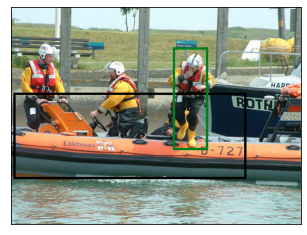

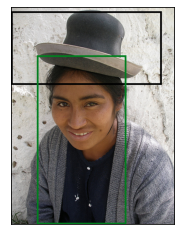

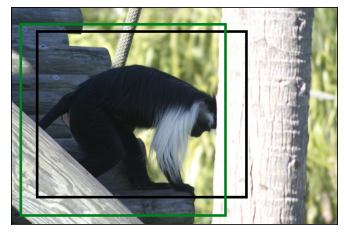

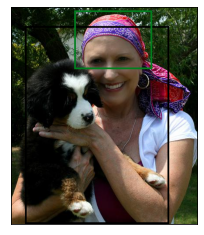

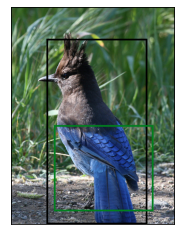

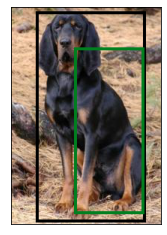

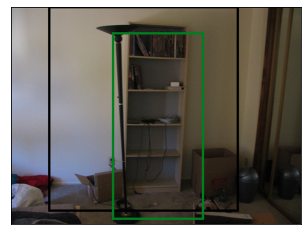

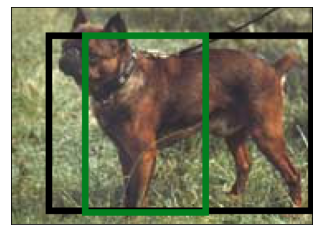

In [ ]:
#score_threshold = .5
#boxes=output['boxes'][output['scores'] > score_threshold]

kval = 2

img_with_boxes = [
    draw_bounding_boxes(F.convert_image_dtype(img, torch.uint8),
                        boxes=output['boxes'][output['labels']!= 100][torch.topk(output['scores'],
                        min(output['scores'].size()[0], kval)).indices], width=4)
    for img, output in zip(images, res)
]
for item in img_with_boxes:
  show(item)

In [ ]:
num = 0
res[num]['labels']

tensor([69,  3, 69,  3, 24, 69, 69,  3, 69, 69, 24,  3,  3,  3,  9,  3,  3,  3,
         3,  3,  9, 24,  3, 69, 11, 69, 69, 69, 11,  3,  3, 77,  3,  3,  3, 91,
        24,  3, 77,  4,  3, 24,  3,  9, 69,  3, 51, 29, 24, 16,  3, 69, 91, 69,
        21, 91, 58, 91, 24,  3, 65,  3,  9, 11,  3, 11,  1], device='cuda:0')

### The truth presented by the targets for comparison:

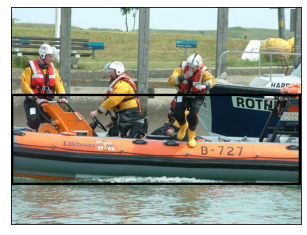

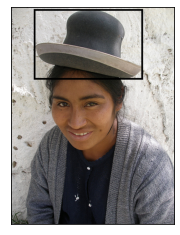

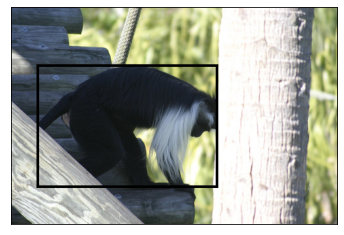

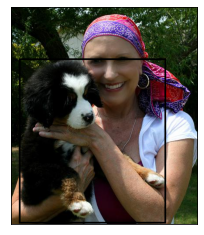

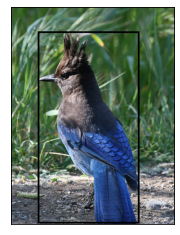

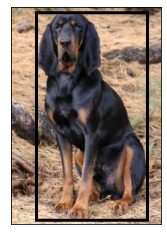

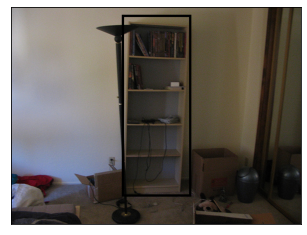

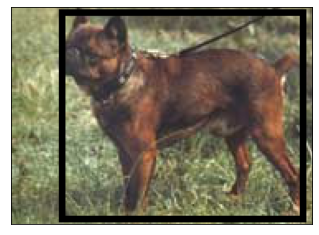

In [ ]:
img_with_boxes = [
    draw_bounding_boxes(F.convert_image_dtype(img, torch.uint8), boxes=output['boxes'], width=4)
    for img, output in zip(images, targets)
]

for item in img_with_boxes:
  show(item)

## 5) Automated Evaluations on the training and validation tests:

In [ ]:
model = model.to(device)
model.eval()

### Testing on training dataset:

In [ ]:
evaluate(model, labeled_training_loader, device=device)

creating index...
index created!
Test:  [   0/3750]  eta: 0:17:10  model_time: 0.1794 (0.1794)  evaluator_time: 0.0331 (0.0331)  time: 0.2747  data: 0.0569  max mem: 18439
Test:  [ 100/3750]  eta: 0:16:14  model_time: 0.1644 (0.1699)  evaluator_time: 0.0316 (0.0324)  time: 0.2544  data: 0.0532  max mem: 18439
Test:  [ 200/3750]  eta: 0:16:47  model_time: 0.1772 (0.1702)  evaluator_time: 0.0313 (0.0499)  time: 0.4485  data: 0.0614  max mem: 18439
Test:  [ 300/3750]  eta: 0:15:54  model_time: 0.1749 (0.1701)  evaluator_time: 0.0313 (0.0441)  time: 0.2621  data: 0.0565  max mem: 18439
Test:  [ 400/3750]  eta: 0:15:21  model_time: 0.1749 (0.1704)  evaluator_time: 0.0329 (0.0412)  time: 0.2593  data: 0.0533  max mem: 18439
Test:  [ 500/3750]  eta: 0:14:51  model_time: 0.1750 (0.1708)  evaluator_time: 0.0306 (0.0394)  time: 0.2592  data: 0.0514  max mem: 18439
Test:  [ 600/3750]  eta: 0:14:15  model_time: 0.1765 (0.1703)  evaluator_time: 0.0328 (0.0382)  time: 0.2618  data: 0.0520  max mem: 

### Testing on evaluation dataset:

In [ ]:
evaluate(model, labeled_validation_loader, device=device)

creating index...
index created!
Test:  [   0/2500]  eta: 0:10:37  model_time: 0.1752 (0.1752)  evaluator_time: 0.0291 (0.0291)  time: 0.2550  data: 0.0460  max mem: 18439
Test:  [ 100/2500]  eta: 0:10:23  model_time: 0.1773 (0.1727)  evaluator_time: 0.0290 (0.0294)  time: 0.2654  data: 0.0539  max mem: 18439
Test:  [ 200/2500]  eta: 0:09:54  model_time: 0.1690 (0.1706)  evaluator_time: 0.0290 (0.0293)  time: 0.2536  data: 0.0512  max mem: 18439
Test:  [ 300/2500]  eta: 0:10:09  model_time: 0.1775 (0.1716)  evaluator_time: 0.0289 (0.0462)  time: 0.2718  data: 0.0596  max mem: 18439
Test:  [ 400/2500]  eta: 0:09:32  model_time: 0.1763 (0.1711)  evaluator_time: 0.0279 (0.0419)  time: 0.2591  data: 0.0551  max mem: 18439
Test:  [ 500/2500]  eta: 0:08:59  model_time: 0.1747 (0.1707)  evaluator_time: 0.0298 (0.0394)  time: 0.2543  data: 0.0522  max mem: 18439
Test:  [ 600/2500]  eta: 0:08:29  model_time: 0.1769 (0.1707)  evaluator_time: 0.0285 (0.0376)  time: 0.2624  data: 0.0585  max mem: 

## (Unused) Manual Training loop:

(Was used initially, but opted out later for bug-fixing.)

In [ ]:
#optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, main_model.parameters()), lr=0.001, momentum=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

# let's train it for 5 epochs
num_epochs = 5

model.train()
for epoch in range(num_epochs):
    print("----------ooooo----------ooooo----------")
    print(f"epoch #{epoch}")
    # train for one epoch, printing every 50 iterations
    itr = 0
    pbar = tqdm(labeled_training_loader)
    epoch_loss = 0.0
    for images, targets in pbar:
        #print(len(images))
        #print(len(targets))
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        epoch_loss += loss_value

        lr = lr_scheduler.get_last_lr()

        """
        if itr % 10 == 0:
            print(f"Iteration #{itr} lr: {lr} loss: {loss_value}")"""

        pbar.set_postfix_str(s=f"Batch loss {loss_value:.5f} , Average Epoch Loss: {(epoch_loss/(itr+1.0)):.5f}")

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        #Just train on first 200 batches
        """
        if itr == 200:
            break"""

        itr+=1

    # Added to solve memory issues
    optimizer.zero_grad()
    del images
    del targets
    del loss_dict
    del losses
    del loss_value
    torch.cuda.empty_cache()

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset (removed for efficiency)
    #evaluate(main_model, labeled_training_loader, device=device)

----------ooooo----------ooooo----------
epoch #0


  0%|          | 0/3750 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
try:
    print(1)
    optimizer.zero_grad()
    print(2)
    del images
    print(3)
    del targets
    print(4)
    del loss_dict
    print(5)
    del losses
    print(6)
    del loss_value
    print(7)
    torch.cuda.empty_cache()
    print("cleared")
except:
    try:
      torch.cuda.empty_cache()
      print("cleared")
    except:
      pass

1
2
3
4
cleared


## Extra: Experiment to show the situation regarding aspec ratios and sizes in the training set: 

(Commented out after initial results)

In [ ]:
"""
import pandas as pd

df = pd.DataFrame({'x_length': pd.Series(dtype='float'),
                   'y_length': pd.Series(dtype='float'),
                   'aspect_ratio': pd.Series(dtype='float')})

for images, targets in tqdm(labeled_training_loader):
    for target in targets:
      for box in target['boxes']:
        x_len = box[2]-box[0]
        y_len = box[3]-box[1]
        ar = y_len/x_len #This is accidentally reversed here
        df.loc[len(df.index)] = [x_len.item(), y_len.item(), ar.item()] 
        #print(box)
        #print(type(x_len.item()), type(y_len.item()), type(ar.item()))
""";

In [ ]:
#df.to_csv("training_box_info.csv")

In [ ]:
#df[df["x_length"] < 600][df["y_length"] < 600][df["aspect_ratio"] < 6].hist(bins=100, figsize=(15, 10))